In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import preliz as pz
from jax import lax, random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
n_samples = 100 + 1

phi = 0.4
theta = 0.8

noise_scale = 0.5


def generate_arma_1_1_data_for_loop(rng_key, n_samples, phi, theta, noise_scale):
    epsilon = noise_scale * random.normal(rng_key, (n_samples,))

    y = jnp.zeros(n_samples)

    for t in range(1, y.size):
        ar_part = phi * y[t - 1]
        ma_part = theta * epsilon[t - 1]
        y_t = ar_part + ma_part + epsilon[t]
        y = y.at[t].set(y_t)

    return y[1:]


y_foor_loop = generate_arma_1_1_data_for_loop(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

In [3]:
def generate_arma_1_1_data_scan(rng_key, n_samples, phi, theta, noise_scale):
    epsilon = noise_scale * random.normal(rng_key, (n_samples,))

    def arma_step(carry, noise):
        y_prev, epsilon_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * epsilon_prev
        y_t = ar_part + ma_part + noise
        return (y_t, noise), y_t

    init_carry = (0.0, epsilon[0])
    _, y = lax.scan(arma_step, init_carry, epsilon[1:])
    return y


y_scan = generate_arma_1_1_data_scan(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

In [4]:
jnp.allclose(y_foor_loop, y_scan, atol=1e-5)

Array(True, dtype=bool)

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

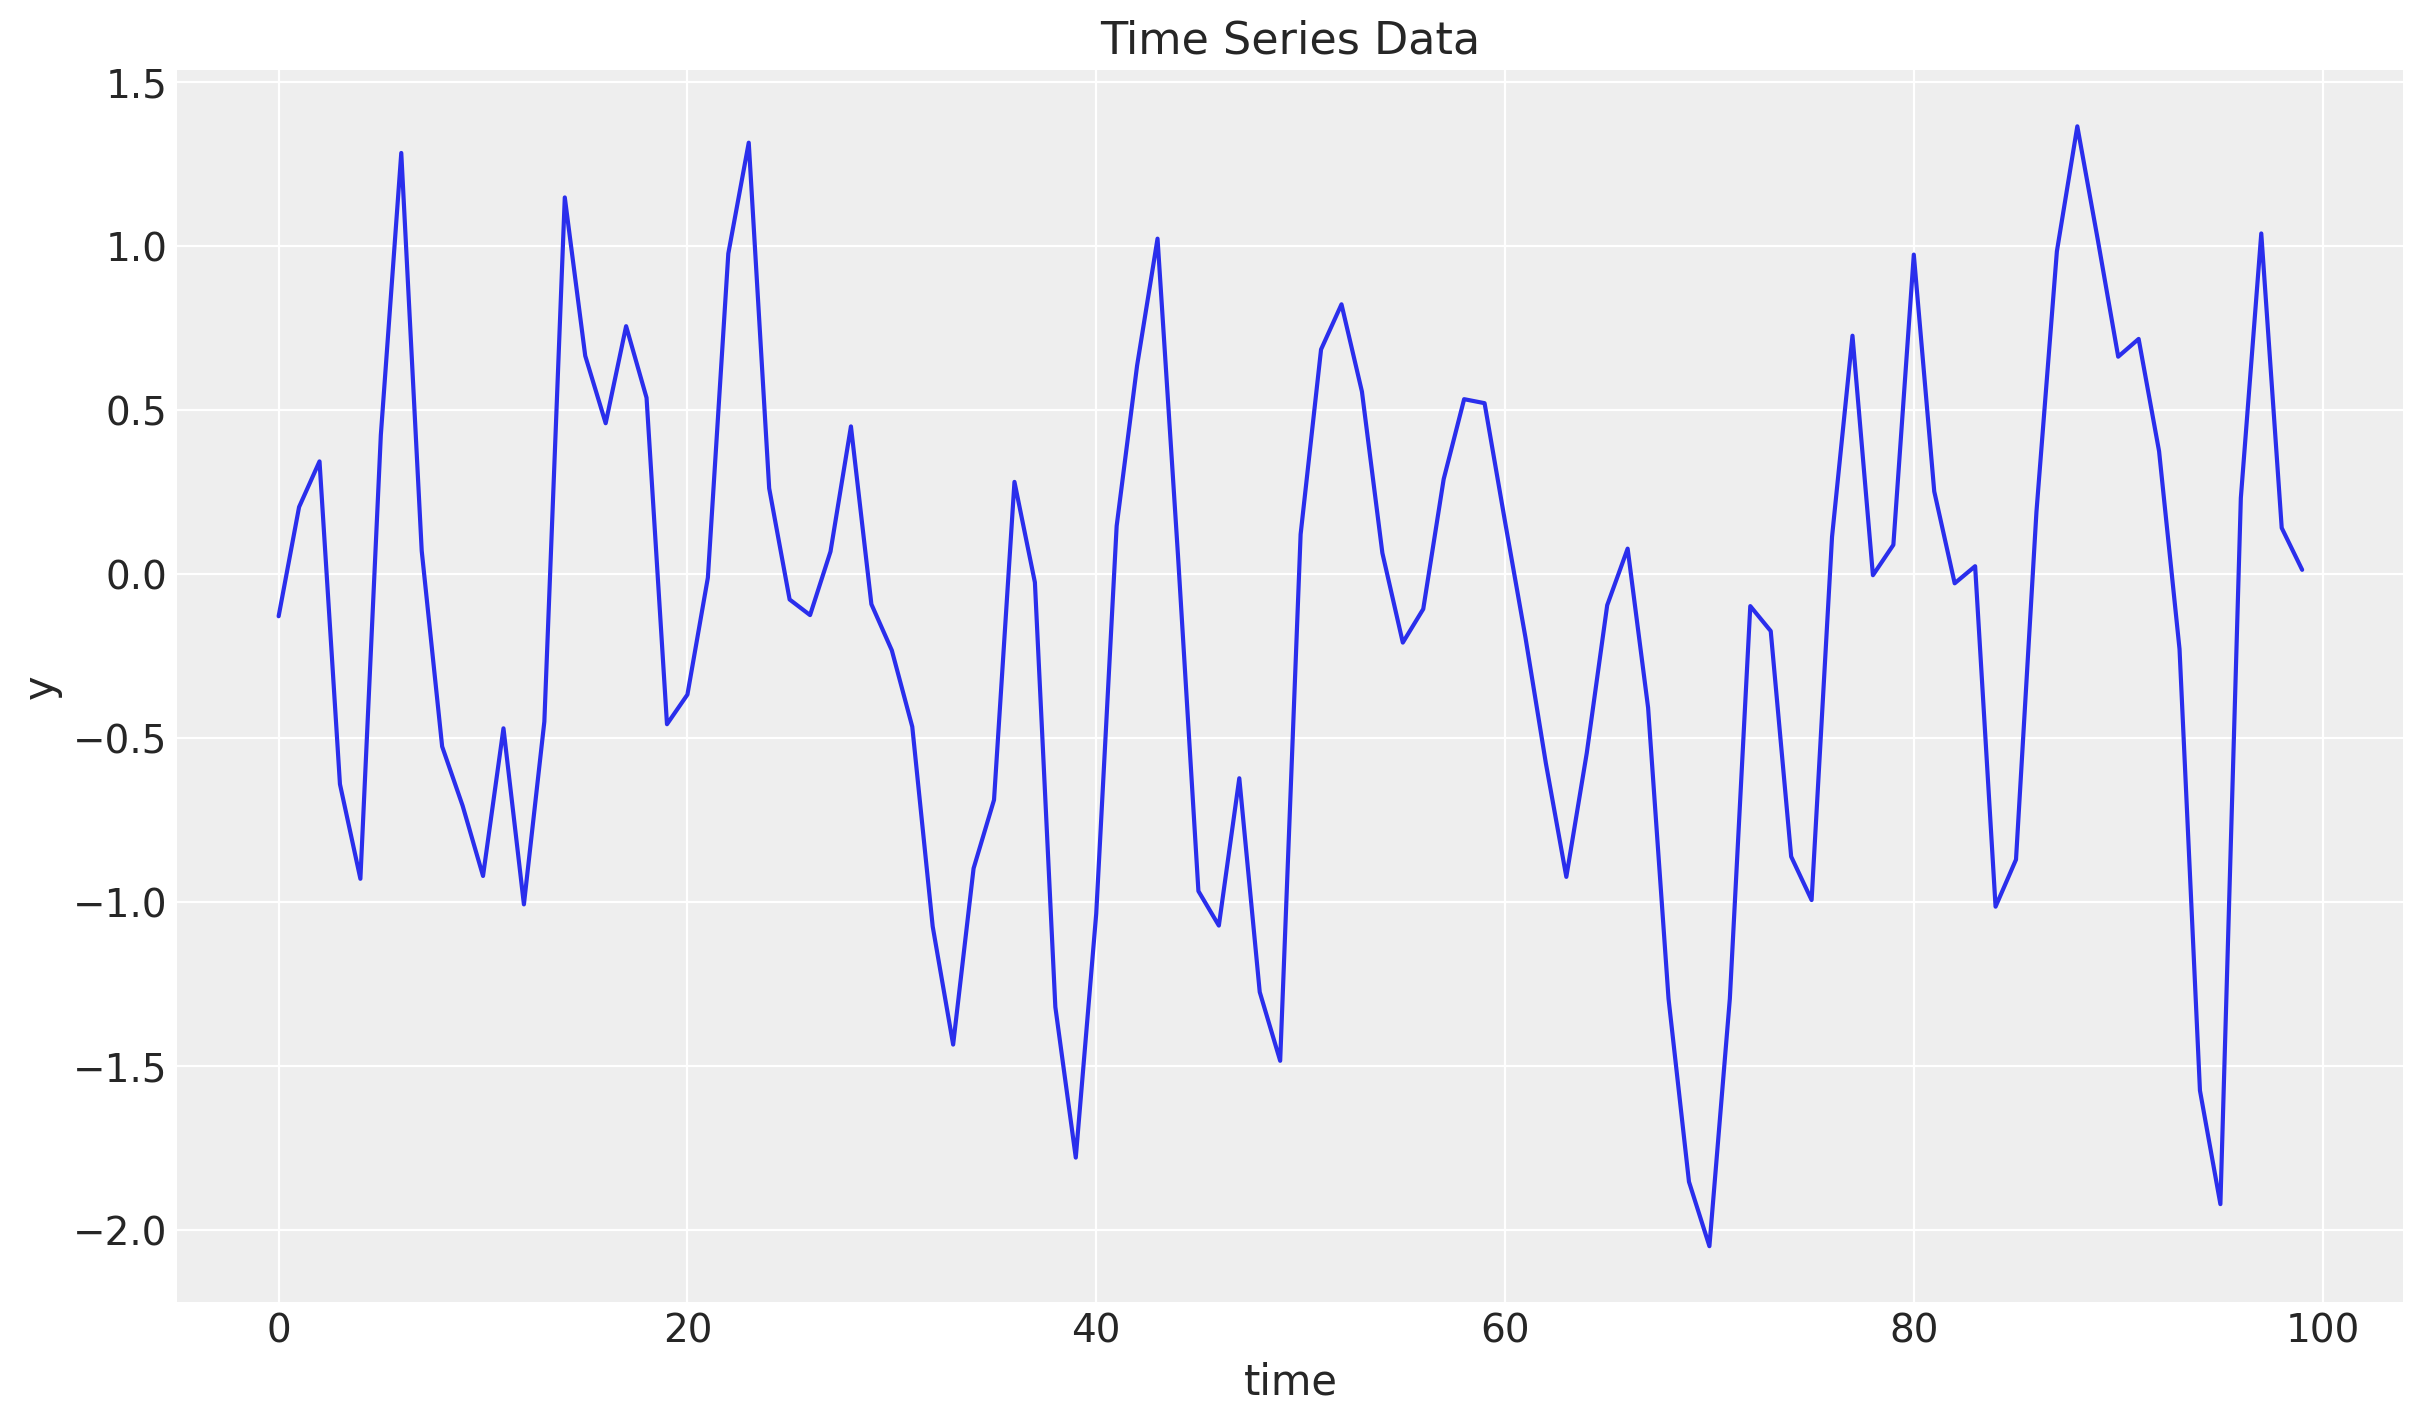

In [5]:
y = y_scan
t = jnp.arange(y.size)

fix, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

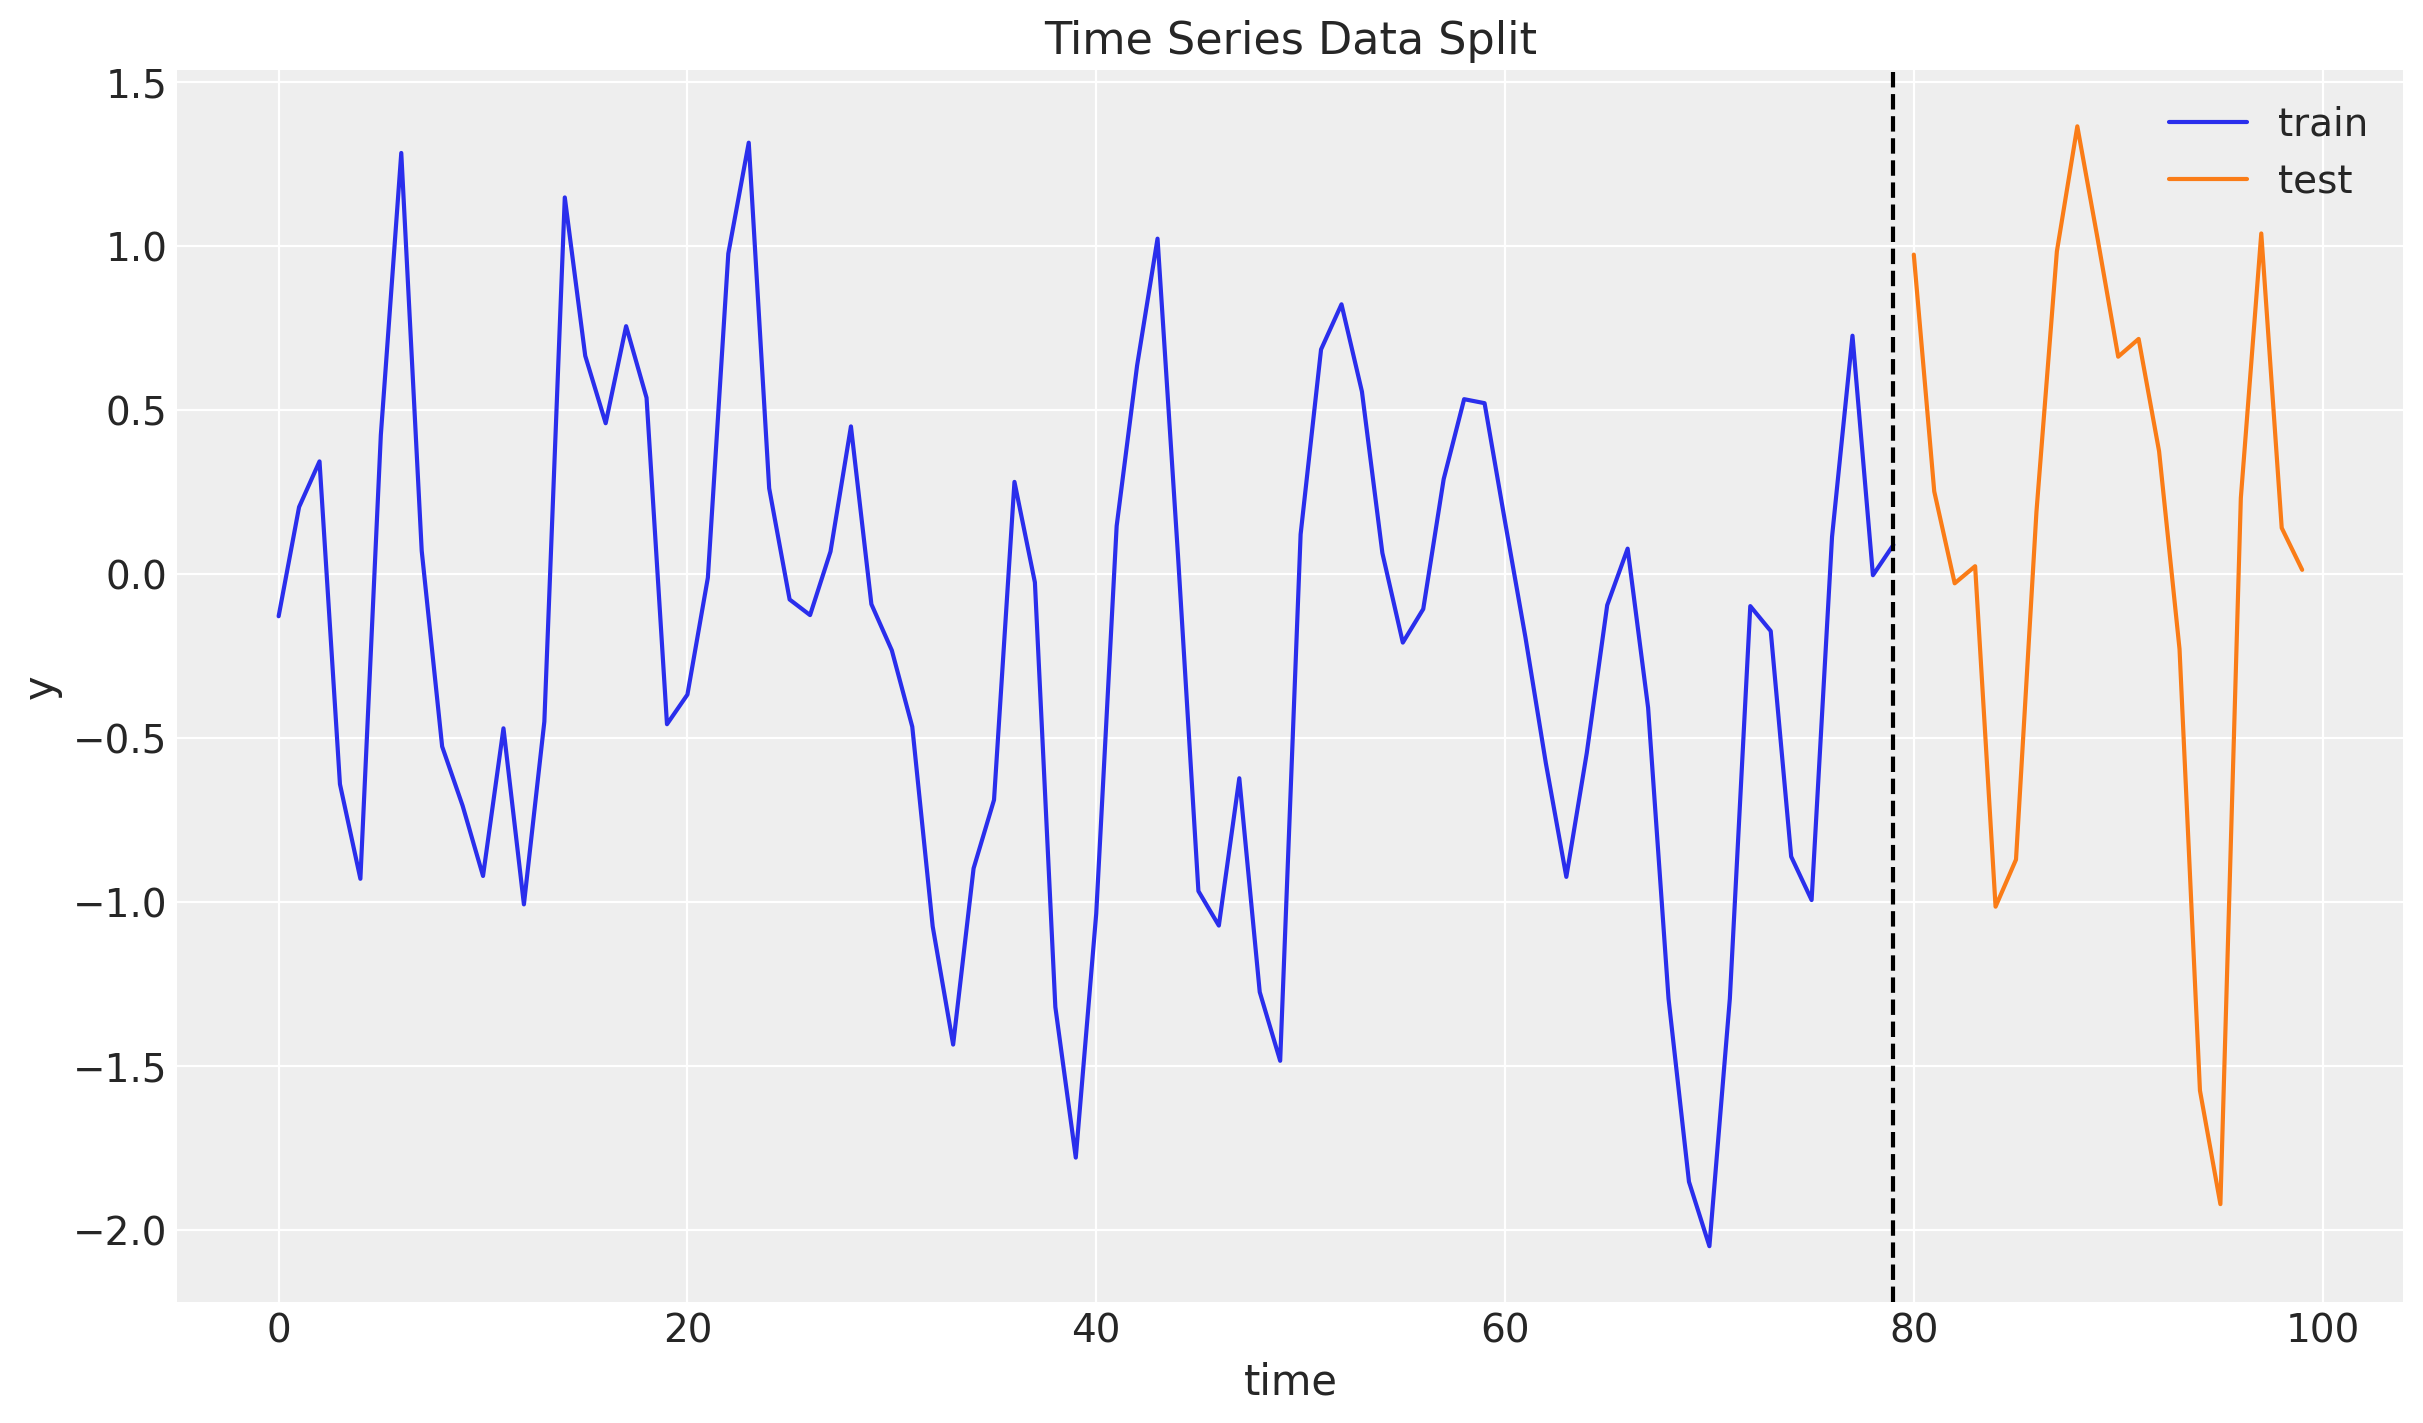

In [6]:
n = y.size

prop_train = 0.8
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## Statsmodels

In [7]:
model = ARIMA(np.asarray(y_train), order=(1, 0, 1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -55.403
Date:                Mon, 12 Feb 2024   AIC                            118.806
Time:                        17:32:54   BIC                            128.334
Sample:                             0   HQIC                           122.626
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2031      0.147     -1.380      0.167      -0.491       0.085
ar.L1          0.3437      0.117      2.937      0.003       0.114       0.573
ma.L1          0.7704      0.074     10.350      0.000       0.625       0.916
sigma2         0.2296      0.043      5.316      0.000       0.145       0.314
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.67   Prob(JB):                         0.57
Heteroskedasticity (H):               0.52   Skew:                             0.12
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
forecast_df = result.get_forecast(steps=y_test.size).summary_frame(alpha=0.94)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA Model Forecast (Statsmodels)')]

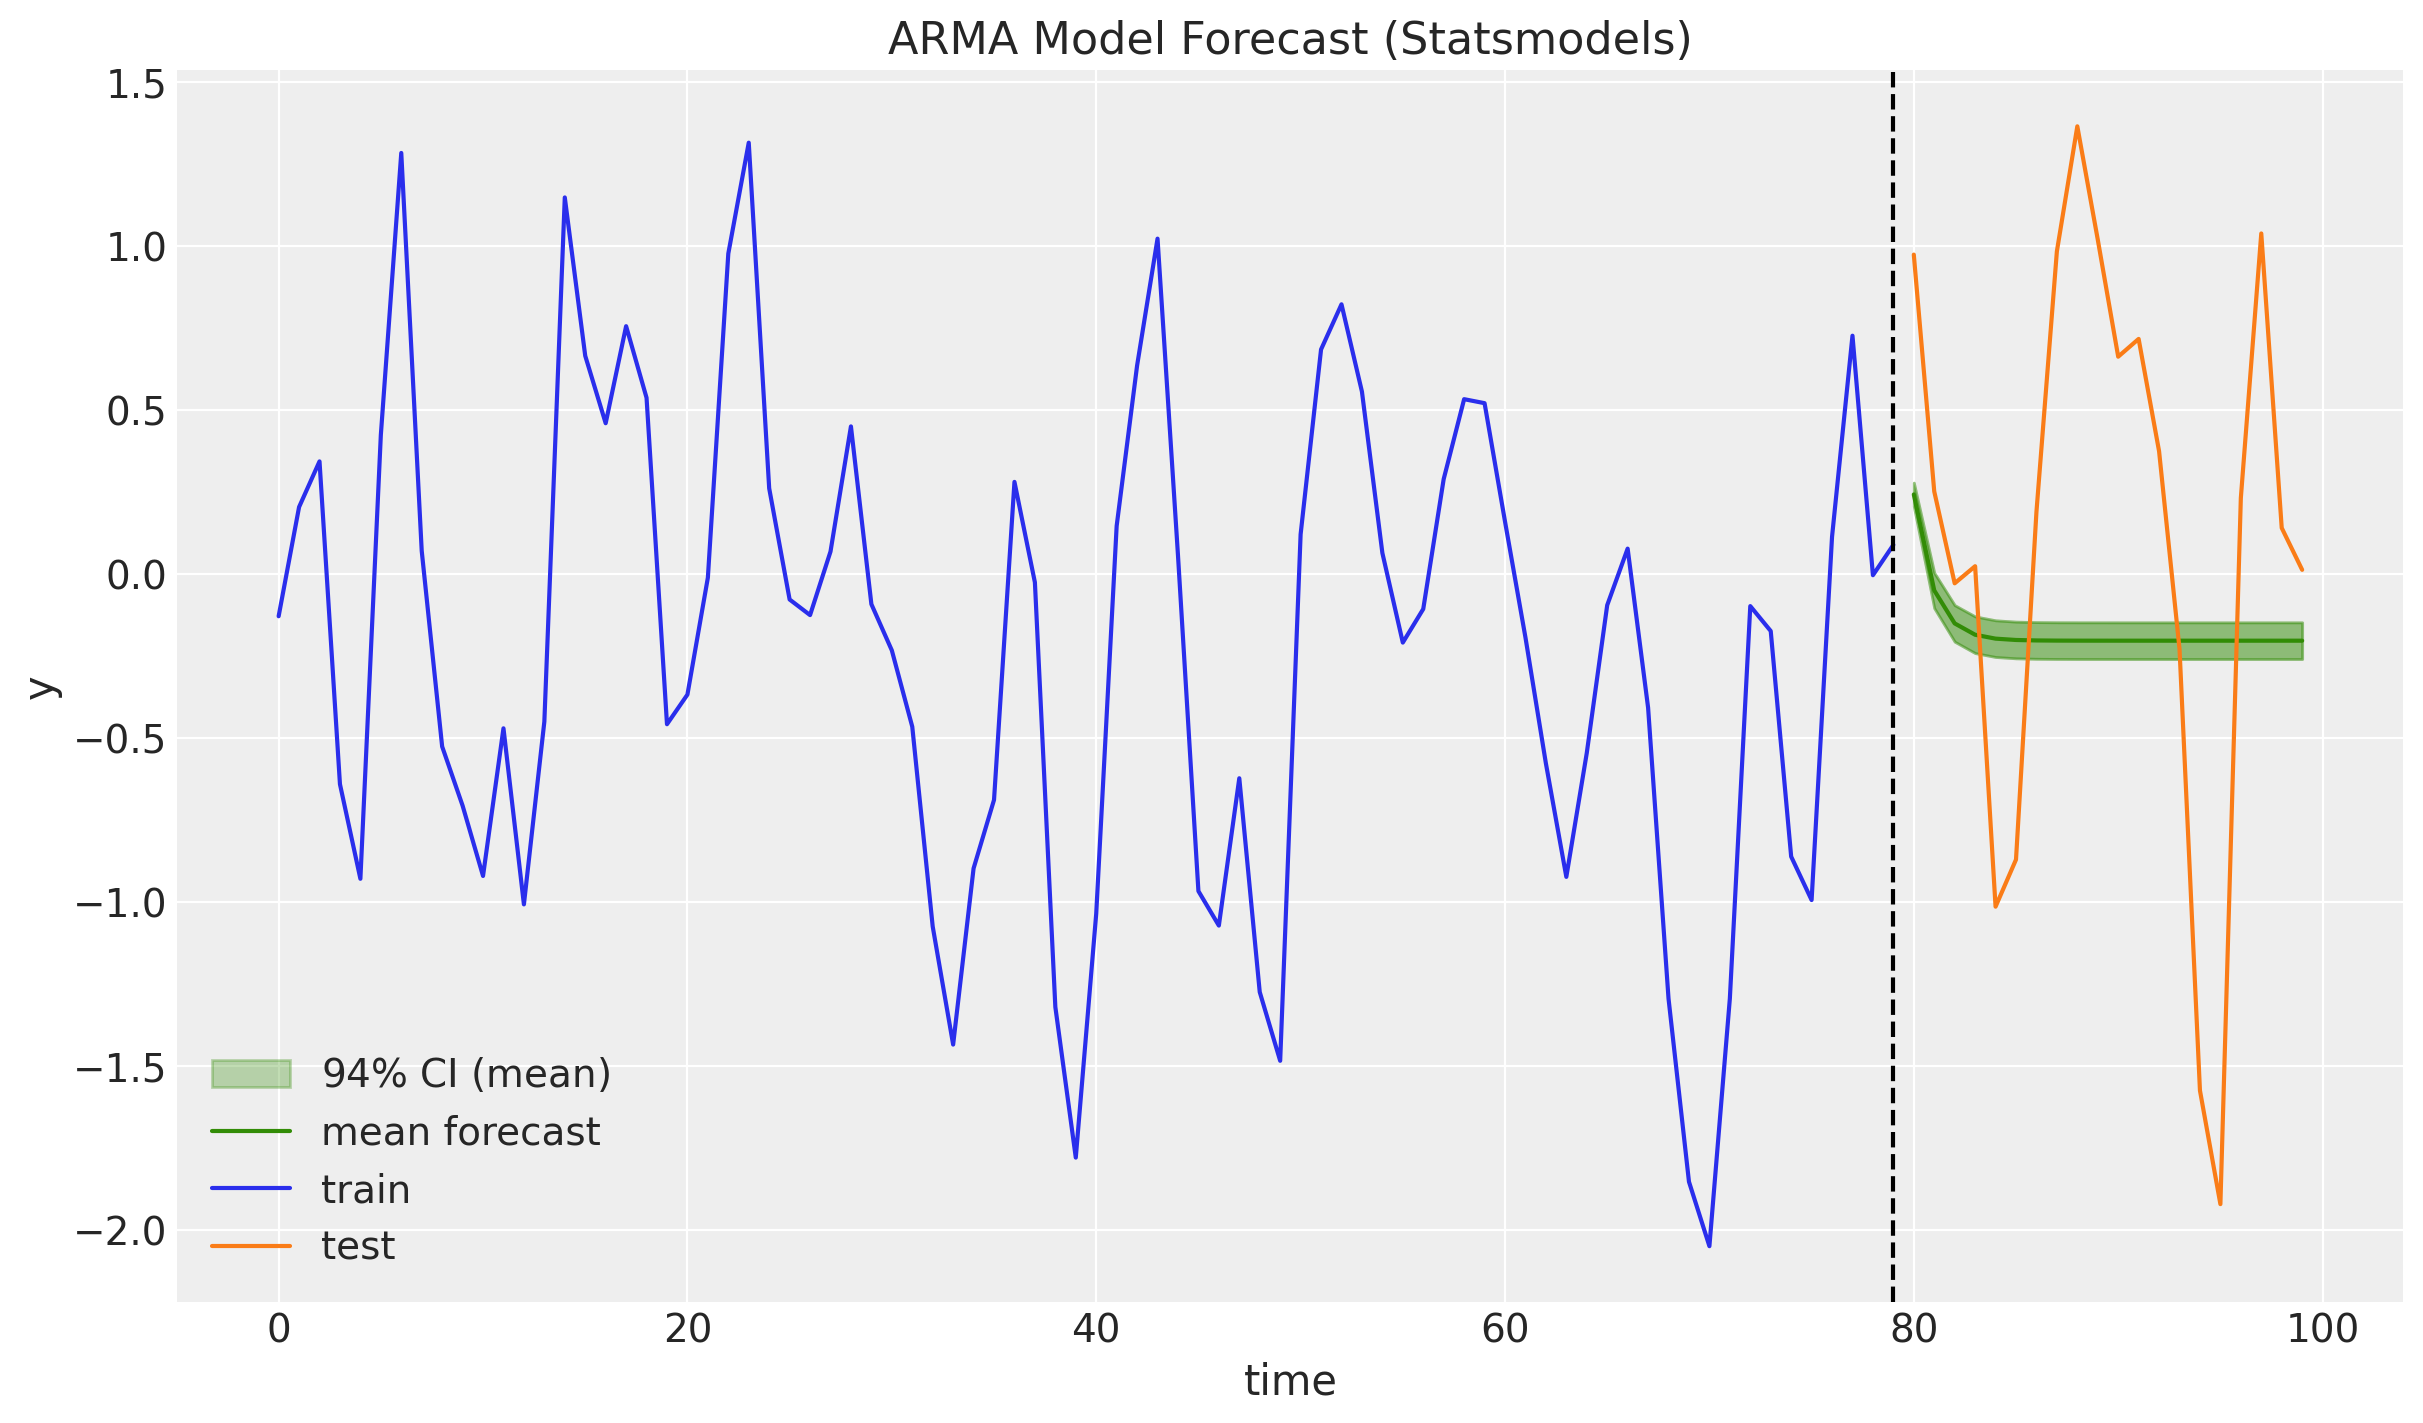

In [9]:
fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean)",
)
ax.fill_between(
    t_test,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
)
ax.plot(t_test, forecast_df["mean"], color="C2", label="mean forecast")
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="ARMA Model Forecast (Statsmodels)")

## NumPyro

In [27]:
def arma_1_1(y: ArrayImpl, future: int = 0) -> None:
    phi = numpyro.sample("phi", dist.Uniform(low=-1, high=1))
    theta = numpyro.sample("theta", dist.Uniform(low=-1, high=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    def transition_fn(carry, t):
        y_prev, error_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * error_prev
        pred = ar_part + ma_part
        error = y[t] - pred
        return (y[t], error), error

    error_0 = y[0]
    _, errors = scan(transition_fn, (y[0], error_0), jnp.arange(1, len(y) + future))
    errors = jnp.concat([error_0[None], errors])
    numpyro.sample("errors", dist.Normal(loc=0, scale=sigma), obs=errors)

In [28]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [29]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, arma_1_1, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [30]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata, var_names="~errors")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['errors'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.398,0.116,0.176,0.614,0.002,0.001,5821.0,4844.0,1.0
sigma,0.498,0.040,0.426,0.576,0.001,0.000,6142.0,5183.0,1.0
theta,0.740,0.083,0.583,0.875,0.001,0.001,5392.0,4611.0,1.0


In [31]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['errors'] have not been found and will be ignored
  warnings.warn(


Text(0.5, 0.98, 'Level Model Trace')

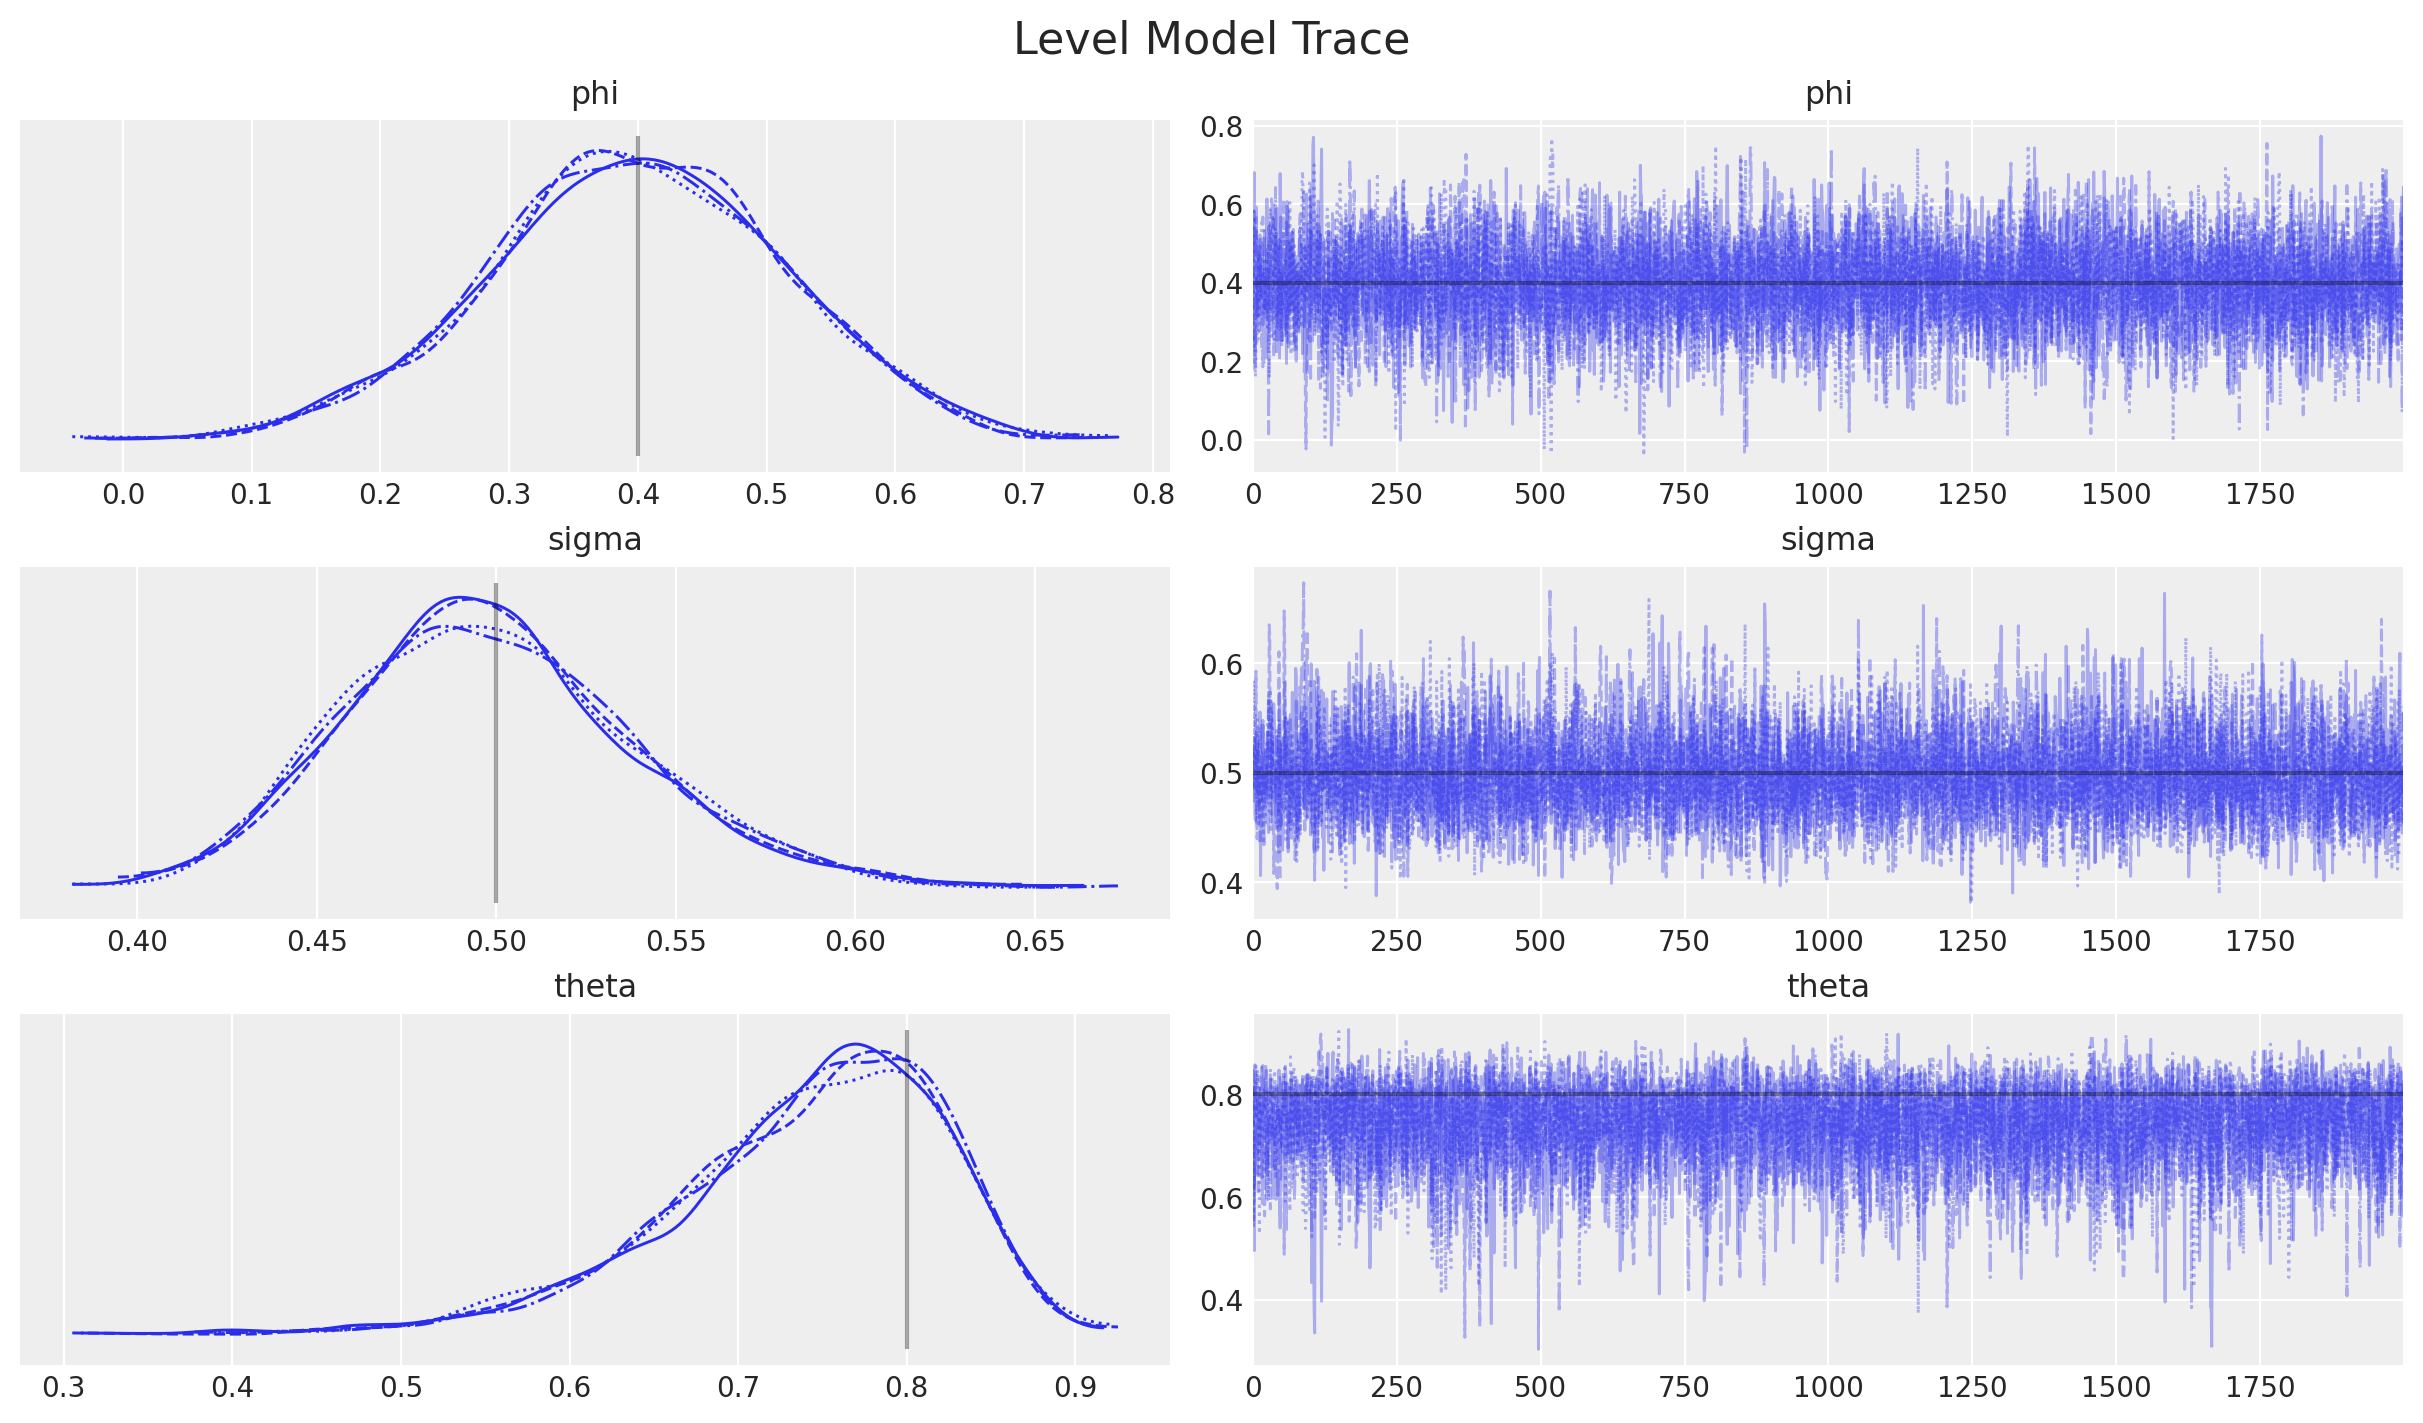

In [32]:
axes = az.plot_trace(
    data=idata,
    var_names="~errors",
    compact=True,
    lines=[("phi", {}, phi), ("theta", {}, theta), ("sigma", {}, noise_scale)],
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Level Model Trace", fontsize=16)

In [26]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast"],
    )
    return predictive(rng_key, *model_args)

In [17]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast = forecast(rng_subkey, arma_1_1, mcmc.get_samples(), y_train, y_test.size)

In [18]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=forecast,
    coords={"t": t_test},
    dims={"y_forecast": ["t"]},
)

StopIteration: 

In [ ]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
# ax.plot(
#     t_test,
#     posterior_predictive["posterior_predictive"]["y_forecast"].mean(
#         dim=("chain", "draw")
#     ),
#     color="C2",
#     label="mean forecast",
# )
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")